<a href="https://colab.research.google.com/github/LawZhou/AtChannel-decentralized-video-platform/blob/master/MIE1624_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/clean_kaggle_data_2020.csv",
                 low_memory=False)
# df = pd.read_csv("data/clean_kaggle_data.csv", low_memory=False)

df = df.drop('Q24', axis=1)
# col Q4_Encoded


# Question 1: Data cleaning

In [2]:
# Drop the numerical features
num_col = ['Time from Start to Finish (seconds)']
df = df.drop(num_col, axis=1)

In [3]:
# Not multiple choice columns
not_mc_cols = []
for col in df.columns:
  if '_' not in col and not 'Q24' in col:
    not_mc_cols.append(col)

In [4]:
mc_cols = []
# Multiple choice columns
for col in df.columns:
  if col not in not_mc_cols and not 'Q24' in col:
    mc_cols.append(col)

In [5]:
df.shape

(10730, 355)

In [6]:
df = df.dropna(axis=0, how='any', thresh=13, subset=not_mc_cols)

In [7]:
df.shape

(10730, 355)

In [8]:
features = df.iloc[1:, :-2].copy()
targets = df.iloc[1:, -2].copy()

In [9]:
features.shape

(10729, 353)

## Clean non-MC columns

In [10]:
features[not_mc_cols].isnull().sum(axis=0)

Q1        0
Q2        0
Q3        0
Q4        0
Q5        0
Q6        0
Q8      561
Q11     561
Q13     561
Q15     561
Q20       0
Q21       0
Q22       0
Q25     159
Q30    7216
Q32    9231
Q38    1253
dtype: int64

In [11]:
not_mc_cols.remove('Q30')
not_mc_cols.remove('Q32')
features = features.drop(['Q30', 'Q32'], axis=1)

In [12]:
# # Keep rows that contain over 13 valid entries
# features = features.dropna(axis=0, how='any', thresh=13, subset=not_mc_cols)
# features[not_mc_cols] = features[not_mc_cols].dropna(axis=0, how='any', thresh=15, subset=None)

# Assign NaN to category 'Unknown'
for col in not_mc_cols:
  features.loc[features[col].isnull(), col] = 'Unknown'

In [13]:
for col in not_mc_cols:
    print(f'Number of unique elements in {col}: {features[col].nunique()}')

Number of unique elements in Q1: 11
Number of unique elements in Q2: 5
Number of unique elements in Q3: 55
Number of unique elements in Q4: 7
Number of unique elements in Q5: 11
Number of unique elements in Q6: 7
Number of unique elements in Q8: 14
Number of unique elements in Q11: 6
Number of unique elements in Q13: 6
Number of unique elements in Q15: 10
Number of unique elements in Q20: 5
Number of unique elements in Q21: 7
Number of unique elements in Q22: 6
Number of unique elements in Q25: 7
Number of unique elements in Q38: 7


In [14]:
features['Q3'].value_counts()

India                                                   2353
United States of America                                1484
Other                                                    815
Brazil                                                   443
Japan                                                    385
Russia                                                   351
United Kingdom of Great Britain and Northern Ireland     350
Germany                                                  256
Nigeria                                                  246
Spain                                                    234
Canada                                                   198
France                                                   197
Italy                                                    184
China                                                    166
Turkey                                                   166
Australia                                                147
Mexico                  

We can find out that Q3 has too many categories that may slow down learning. We can truncate the insignificant ones.

In [15]:
def remove_insiginicances(data, col, threshold):
  counts = data[col].value_counts()
  value_mask = data[col].isin(counts.index[counts < threshold])
  data.loc[value_mask,col] = "Other"
# remove categories appearing below 100 times
remove_insiginicances(features, 'Q3', 100)
features['Q3'].value_counts()

Other                                                   2713
India                                                   2353
United States of America                                1484
Brazil                                                   443
Japan                                                    385
Russia                                                   351
United Kingdom of Great Britain and Northern Ireland     350
Germany                                                  256
Nigeria                                                  246
Spain                                                    234
Canada                                                   198
France                                                   197
Italy                                                    184
Turkey                                                   166
China                                                    166
Australia                                                147
Mexico                  

In [16]:
# one-hot encoding
features = pd.get_dummies(data=features, columns=not_mc_cols)

In [17]:
features.head()

,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,Q10_Part_8,Q10_Part_9,Q10_Part_10,Q10_Part_11,Q10_Part_12,Q10_Part_13,Q10_OTHER,Q12_Part_1,...,Q15_2-3 years,Q15_20 or more years,Q15_3-4 years,Q15_4-5 years,Q15_5-10 years,Q15_I do not use machine learning methods,Q15_Under 1 year,Q15_Unknown,Q20_0-49 employees,"Q20_10,000 or more employees","Q20_1000-9,999 employees",Q20_250-999 employees,Q20_50-249 employees,Q21_0,Q21_1-2,Q21_10-14,Q21_15-19,Q21_20+,Q21_3-4,Q21_5-9,Q22_I do not know,Q22_No (we do not use ML methods),Q22_We are exploring ML methods (and may one day put a model into production),"Q22_We have well established ML methods (i.e., models in production for more than 2 years)","Q22_We recently started using ML methods (i.e., models in production for less than 2 years)",Q22_We use ML methods for generating insights (but do not put working models into production),Q25_$0 ($USD),Q25_$1-$99,"Q25_$10,000-$99,999","Q25_$100,000 or more ($USD)",Q25_$100-$999,"Q25_$1000-$9,999",Q25_Unknown,"Q38_Advanced statistical software (SPSS, SAS, etc.)","Q38_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Q38_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Q38_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Q38_Local development environments (RStudio, JupyterLab, etc.)",Q38_Other,Q38_Unknown
1,Python,R,SQL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Visual Studio,NaN,PyCharm,NaN,NaN,Sublime Text,NaN,NaN,NaN,NaN,NaN,Colab Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GPUs,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,NaN,NaN,NaN,NaN,NaN,Java,Javascript,NaN,NaN,Bash,NaN,NaN,NaN,NaN,NaN,NaN,Visual Studio Code (VSCode),NaN,NaN,Notepad++,Sublime Text,Vim / Emacs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,Python,NaN,SQL,NaN,NaN,NaN,NaN,NaN,NaN,Bash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PyCharm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,Python,NaN,SQL,NaN,NaN,NaN,NaN,NaN,NaN,Bash,NaN,NaN,NaN,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",NaN,NaN,NaN,PyCharm,NaN,NaN,Sublime Text,Vim / Emacs,NaN,NaN,NaN,Kaggle Notebooks,Colab Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GPUs,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
5,NaN,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RStudio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0


## Clean MC columns

In [18]:
# Fill NaNs with 0 and others with 1
dummies = features[mc_cols].fillna(0)
dummies[dummies != 0] = 1
features[mc_cols] = dummies

In [19]:
features.head()

,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,Q10_Part_8,Q10_Part_9,Q10_Part_10,Q10_Part_11,Q10_Part_12,Q10_Part_13,Q10_OTHER,Q12_Part_1,...,Q15_2-3 years,Q15_20 or more years,Q15_3-4 years,Q15_4-5 years,Q15_5-10 years,Q15_I do not use machine learning methods,Q15_Under 1 year,Q15_Unknown,Q20_0-49 employees,"Q20_10,000 or more employees","Q20_1000-9,999 employees",Q20_250-999 employees,Q20_50-249 employees,Q21_0,Q21_1-2,Q21_10-14,Q21_15-19,Q21_20+,Q21_3-4,Q21_5-9,Q22_I do not know,Q22_No (we do not use ML methods),Q22_We are exploring ML methods (and may one day put a model into production),"Q22_We have well established ML methods (i.e., models in production for more than 2 years)","Q22_We recently started using ML methods (i.e., models in production for less than 2 years)",Q22_We use ML methods for generating insights (but do not put working models into production),Q25_$0 ($USD),Q25_$1-$99,"Q25_$10,000-$99,999","Q25_$100,000 or more ($USD)",Q25_$100-$999,"Q25_$1000-$9,999",Q25_Unknown,"Q38_Advanced statistical software (SPSS, SAS, etc.)","Q38_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Q38_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Q38_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Q38_Local development environments (RStudio, JupyterLab, etc.)",Q38_Other,Q38_Unknown
1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [20]:
# turn into array
feature_col_names = features.columns
features = features.values
targets = targets.values

# Split train test

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     features, targets, test_size=0.2, random_state=42)
print(f"Shape of train features: {X_train.shape}")
print(f"Shape of test features: {X_test.shape}")

Shape of train features: (8583, 468)
Shape of test features: (2146, 468)


# Question 2: Exploratory data analysis and feature selection 

In [22]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
sel = SelectKBest(mutual_info_classif, k=20)
X_train = sel.fit_transform(X_train, y_train)
X_test = sel.transform(X_test)

In [23]:
# k most important features
feature_col_names[sel.get_support(indices=True)]

Index(['Q23_Part_3', 'Q26_A_Part_1', 'Q27_A_Part_1', 'Q1_18-21', 'Q1_22-24',
       'Q3_India', 'Q3_Japan', 'Q3_Spain', 'Q3_United States of America',
       'Q6_20+ years', 'Q6_< 1 years', 'Q15_10-20 years', 'Q15_5-10 years',
       'Q20_0-49 employees', 'Q20_10,000 or more employees', 'Q21_0',
       'Q21_20+',
       'Q22_We have well established ML methods (i.e., models in production for more than 2 years)',
       'Q25_$1-$99', 'Q25_$100,000 or more ($USD)'],
      dtype='object')

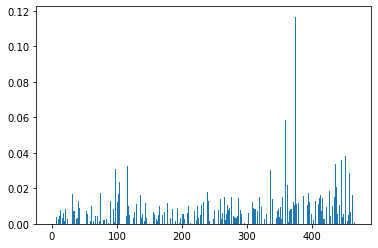

In [24]:
# plot feature importances of all feature
plt.bar([x for x in range(len(sel.scores_))], sel.scores_)
plt.show()

# Question 3 Model implementation

In [25]:
from sklearn.linear_model import LogisticRegression
# Ordinal logistic regression

class OrdinalLogits():
  def __init__(self, n_class, hyperparams={}):
    self.clfs = {}
    self.n_class = n_class
    self.hyperparams = hyperparams

  def fit(self, X, y):
    classes = np.unique(y)
    for cls in classes:
      if cls == np.max(classes):
        continue
      cls_0_idx = y <= cls
      cls_1_idx = y > cls
      ordinal_y = np.array(y)
      ordinal_y[cls_0_idx] = 0
      ordinal_y[cls_1_idx] = 1
      clf = LogisticRegression(**self.hyperparams).fit(X, ordinal_y)
      self.clfs[int(cls)] = clf


  def predict(self, X):
    probs = np.zeros((X.shape[0], self.n_class))
    for cls in range(self.n_class):
      if cls == self.n_class-1:
        clf = self.clfs[cls-1]
      else:
        clf = self.clfs[cls]
      predicted_y = clf.predict_proba(X)

      if cls == 0:
        probs[:, 0] = predicted_y[:, 0]
      elif cls == self.n_class-1:
        probs[:, self.n_class-1] = predicted_y[:, 1]
      else:
        prev_clf_probs = self.clfs[cls-1].predict_proba(X)
        probs[:, cls] = predicted_y[:, 0] - prev_clf_probs[:, 0]
    predictions = np.argmax(probs, axis=1)
    return predictions

  def get_hyperparams(self):
    return self.hyperparams


In [26]:
f1_avg = 'macro'

In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
def run_kfold(X, y, model, f1_avg, n_splits=10):  
    skf = StratifiedKFold(n_splits=n_splits)
    f1_val = np.zeros(n_splits)
    fold = 0
    
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model.fit(X_train, y_train)
        predictions_train = model.predict(X_train)
        predictions_val = model.predict(X_val)
        
        f1_val[fold] = f1_score(y_val, predictions_val, average=f1_avg)
       
        fold += 1   
        
    f1_mean = np.mean(f1_val)
    f1_var=np.var(f1_val)
    return f1_mean, f1_var 

# Question 4

In [28]:
from sklearn.model_selection import ParameterGrid
def tune_hyperparams(X, y, params, f1_avg, n_fold=10):
  n_class = len(np.unique(y))
  param_grid = list(ParameterGrid(params))
  model_scores = {}
  for param in param_grid:
    print(f"Running {n_fold}-fold with hyperparameters: {param}")
    model = OrdinalLogits(n_class=n_class, hyperparams = param)
    f1_mean, f1_var = run_kfold(X, y, model, f1_avg, n_fold)
    model_scores[f1_mean] = model
    print(f"Ending with {round(f1_mean, 3)} f1-score mean and {round(f1_var, 6)} f1-score variance")
  # return the model with the best f1 score
  return model_scores[max(model_scores, key=float)]
param_grid = {'C': [0.01, 0.1, 1, 10, 50, 100], 'class_weight': ['balanced', None]}
best_model = tune_hyperparams(X_train, y_train, param_grid, f1_avg)

Running 10-fold with hyperparameters: {'C': 0.01, 'class_weight': 'balanced'}
Ending with 0.049 f1-score mean and 1e-06 f1-score variance
Running 10-fold with hyperparameters: {'C': 0.01, 'class_weight': None}
Ending with 0.075 f1-score mean and 2e-05 f1-score variance
Running 10-fold with hyperparameters: {'C': 0.1, 'class_weight': 'balanced'}
Ending with 0.051 f1-score mean and 6e-06 f1-score variance
Running 10-fold with hyperparameters: {'C': 0.1, 'class_weight': None}
Ending with 0.096 f1-score mean and 2.8e-05 f1-score variance
Running 10-fold with hyperparameters: {'C': 1, 'class_weight': 'balanced'}
Ending with 0.053 f1-score mean and 7e-06 f1-score variance
Running 10-fold with hyperparameters: {'C': 1, 'class_weight': None}
Ending with 0.107 f1-score mean and 9.4e-05 f1-score variance
Running 10-fold with hyperparameters: {'C': 10, 'class_weight': 'balanced'}
Ending with 0.054 f1-score mean and 8e-06 f1-score variance
Running 10-fold with hyperparameters: {'C': 10, 'class_wei

In [29]:
best_model.get_hyperparams()

{'C': 1, 'class_weight': None}

In [30]:
f1_mean, f1_var = run_kfold(X_train, y_train, best_model, f1_avg)
print(f'The average f1 score on 10-fold using the best model: {round(f1_mean, 3)}')
print(f'The variance of f1 scores on 10-fold using the best model: {round(f1_var, 6)}')

The average f1 score on 10-fold using the best model: 0.107
The variance of f1 scores on 10-fold using the best model: 9.4e-05


# Question 5

In [31]:
prediction_train = best_model.predict(X_train)
f1_score(y_train, prediction_train, average=f1_avg)

0.11335840558348753

In [32]:
prediction_test = best_model.predict(X_test)
f1_score(y_test, prediction_test, average=f1_avg)

0.09457318887226464

Text(0.5, 1.0, 'Training set predictions')

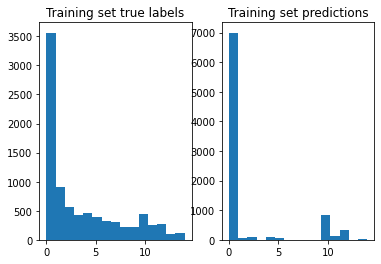

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(y_train, bins=15)
ax1.set_title('Training set true labels')
ax2.hist(prediction_train, bins=15)
ax2.set_title('Training set predictions')

Text(0.5, 1.0, 'Testing set predictions')

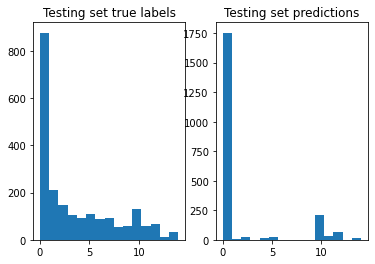

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(y_test, bins=15)
ax1.set_title('Testing set true labels')
ax2.hist(prediction_test, bins=15)
ax2.set_title('Testing set predictions')